In [2]:
# importo las librearias que voy a utilizar
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

In [3]:
# carga inicial del csv
df = pd.read_csv('AccidentesAviones.csv')

Primer analisis del dataframe

In [4]:
df.shape

(5008, 18)

In [5]:
df.columns

Index(['Unnamed: 0', 'fecha', 'HORA declarada', 'Ruta', 'OperadOR',
       'flight_no', 'route', 'ac_type', 'registration', 'cn_ln', 'all_aboard',
       'PASAJEROS A BORDO', 'crew_aboard', 'cantidad de fallecidos',
       'passenger_fatalities', 'crew_fatalities', 'ground', 'summary'],
      dtype='object')

In [6]:
# renombro las columnas
df.columns =['Unnamed: 0','date', 'time', 'location', 'operator', 'flight', 'route', 'type', 
                  'registration', 'cn/ln', 'all_aboard', 'passengers_aboard', 
                  'crew_aboard', 'total_fatalities', 'passengers_fatalities', 
                  'crew_fatalities', 'ground', 'summary']

In [7]:
# vemos el tipo de dato de las columnas ya renombradas
df.dtypes

Unnamed: 0                int64
date                     object
time                     object
location                 object
operator                 object
flight                   object
route                    object
type                     object
registration             object
cn/ln                    object
all_aboard               object
passengers_aboard        object
crew_aboard              object
total_fatalities         object
passengers_fatalities    object
crew_fatalities          object
ground                   object
summary                  object
dtype: object

In [8]:
# vamos a ver como estan los datos
df.head()

,Unnamed: 0,date,time,location,operator,flight,route,type,registration,cn/ln,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [9]:
# tras examinar el csv con otra herramienta, vamos a dropear las columnas que no necesitas y las que no podemos utilizar por la cantidad
# de nulos que contienen
df.drop(columns= ['Unnamed: 0'], inplace=True)
df.drop(columns=['flight'], inplace=True)
df.drop(columns=['cn/ln'], inplace=True)
df.drop(columns=['registration'], inplace=True)

In [10]:
# convertimos la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')

# reemplazamos datos incorrectos en la columna 'time' y vamos a formatearla como los primeros 2 numeros:minutos 2 numeros,
# luego la convertimos a datetime con formato hora:minuto y rellenamos los valores faltantes con '00:00'
df['time'] = df['time'].str.replace('[^0-9]+', '', regex=True)
df['time'] = df['time'].str[:2] + ':' + df['time'].str[2:]
df['time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.strftime('%H:%M')
df['time'].fillna('00:00', inplace=True)

# combinamos las columnas 'date' y 'time' en una sola columna 'datetime' y eliminamos la columna 'time'
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str)).dt.floor('min')
df.drop(columns=['date', 'time'], inplace=True)

In [11]:
df.head()

,location,operator,route,type,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground,summary,datetime
0,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",1908-09-17 17:18:00
1,"Juvisy-sur-Orge, France",?,Air show,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,1909-09-07 00:00:00
2,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...,1912-07-12 06:30:00
3,"Victoria, British Columbia, Canada",Private,?,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...,1913-08-06 00:00:00
4,Over the North Sea,Military - German Navy,?,Zeppelin L-1 (airship),20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...,1913-09-09 18:30:00


In [12]:
# obtenemos el índice de la columna 'datetime'
datetime_index = df.columns.get_loc('datetime')

# movemos la columna 'datetime' al primer lugar
cols = df.columns.tolist()
cols = [cols[datetime_index]] + cols[:datetime_index] + cols[datetime_index+1:]
df = df[cols]

In [13]:
# ahora vamos a reemplazar los '?' de todas las columnas
columns_to_fill = {
    "location": "No data",
    "operator": "No data",
    "route": "No data",
    "type": "No data",
    "summary": "No data",
    "all_aboard": "0",
    "passengers_aboard": "0",
    "crew_aboard":"0",
    "total_fatalities":"0",
    "passengers_fatalities":"0",
    "crew_fatalities":"0",
    "ground":"0"
    }

for column, value in columns_to_fill.items():
    df[column] = df[column].replace('?', value)

In [14]:
# cambiamos las columnas al tipo de dato correspondiente
df['all_aboard'] = pd.to_numeric(df['all_aboard'], errors='coerce')
df['passengers_aboard'] = pd.to_numeric(df['passengers_aboard'], errors='coerce')
df['crew_aboard'] = pd.to_numeric(df['crew_aboard'], errors='coerce')
df['total_fatalities'] = pd.to_numeric(df['total_fatalities'], errors='coerce')
df['passengers_fatalities'] = pd.to_numeric(df['passengers_fatalities'], errors='coerce')
df['crew_fatalities'] = pd.to_numeric(df['crew_fatalities'], errors='coerce')
df['ground'] = pd.to_numeric(df['ground'], errors='coerce')

In [15]:
df.head()

,datetime,location,operator,route,type,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground,summary
0,1908-09-17 17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07 00:00:00,"Juvisy-sur-Orge, France",No data,Air show,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,1912-07-12 06:30:00,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,1913-08-06 00:00:00,"Victoria, British Columbia, Canada",Private,No data,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,1913-09-09 18:30:00,Over the North Sea,Military - German Navy,No data,Zeppelin L-1 (airship),20,0,0,14,0,0,0,The airship flew into a thunderstorm and encou...


In [ ]:
# realizamos un procesamiento de texto y analisis de frecuencia de la columna 'summary'
summary_data = df['summary'].tolist()
stop_words = set(stopwords.words('english'))
word_frequencies = defaultdict(int)
for summary in summary_data:
    tokens = word_tokenize(summary)
    filtered_words = [word.lower() for word in tokens if word.isalpha(
    ) and word.lower() not in stop_words and len(word) > 2]
    for word in filtered_words:
        word_frequencies[word] += 1
sorted_word_frequencies = sorted(
    word_frequencies.items(), key=lambda x: x[1], reverse=True)
for word, frequency in sorted_word_frequencies:
    print(f"{word}: {frequency}")

In [17]:
def category_summary(searchIn, word_frequencies):
    """
    Categoriza un resumen de texto dado basándose en coincidencias de palabras clave.

    Args:
        searchIn (str): El resumen de texto que se va a categorizar.
        word_frequencies (dict): Un diccionario que contiene las frecuencias de las palabras.

    Returns:
        str: La categoría asignada al resumen de texto. Las posibles categorías son:
            - 'clima': Incidentes relacionados con el clima.
            - 'derribo': Incidentes que involucran disparos o ataques de misiles.
            - 'despegue': Incidentes relacionados con el despegue.
            - 'falla': Incidentes causados por fallas o mal funcionamiento del equipo.
            - 'aterrizaje': Incidentes relacionados con el aterrizaje.

            Si no se encuentra ninguna categoría coincidente, se devuelve 'indeterminado'.
    """
    
    weather_keywords = ['lightning', 'storm', 'rain', 'fog', 'foggy', 'wind', 'winds', 'weather', 'blizzard',
                        'cloud', 'thunderstorm', 'thunderstorms', 'rainstorm', 'visibility', 'snowstorm', 'clouds', 'poor']
    derribo_keywords = ['shot', 'missile', 'shell', 'mortar', 'machine gun']
    despegue_keywords = ['taking', 'takeoff', 'take', 'off', 'taking off', 'taken off']
    falla_keywords = ['controls', 'fuel', 'failure', 'fail', 'failed', 'malfunction', 'malfunctioning', 'malfunctions', 'separated', 'broke', 'broke-up']
    aterrizaje_keywords = ['approach', 'landing', 'land', 'to land', 'short of the runway', 'overshot']

    for word in searchIn.split():
        if any(re.search(r'\b' + re.escape(word) + r'\b', searchIn, re.IGNORECASE) for word in weather_keywords):
            return 'clima'
        elif any(re.search(r'\b' + re.escape(word) + r'\b', searchIn, re.IGNORECASE) for word in derribo_keywords):
            return 'derribo'
        elif any(re.search(r'\b' + re.escape(word) + r'\b', searchIn, re.IGNORECASE) for word in despegue_keywords):
            return 'despegue'
        elif any(re.search(r'\b' + re.escape(word) + r'\b', searchIn, re.IGNORECASE) for word in falla_keywords):
            return 'falla'
        elif any(re.search(r'\b' + re.escape(word) + r'\b', searchIn, re.IGNORECASE) for word in aterrizaje_keywords):
            return 'aterrizaje'

    return 'indeterminado'

df['category'] = df['summary'].apply(lambda row: category_summary(row, word_frequencies))

In [ ]:
# realizamos un procesamiento de texto y analisis de frecuencia de la columna 'operator'
summary_data = df['operator'].tolist()
stop_words = set(stopwords.words('english'))
word_frequencies = defaultdict(int)
for summary in summary_data:
    tokens = word_tokenize(summary)
    filtered_words = [word.lower() for word in tokens if word.isalpha(
    ) and word.lower() not in stop_words and len(word) > 2]
    for word in filtered_words:
        word_frequencies[word] += 1
sorted_word_frequencies = sorted(
    word_frequencies.items(), key=lambda x: x[1], reverse=True)
for word, frequency in sorted_word_frequencies:
    print(f"{word}: {frequency}")

In [19]:
def operator_summary(searchIn, word_frequencies):
    """
    Calcula el tipo de operador a partir del texto de búsqueda y las frecuencias de palabras.

    Parameters:
        searchIn (str): El texto en el que se buscará el tipo de operador.
        word_frequencies (defaultdict): Un diccionario de frecuencias de palabras.

    Returns:
        str: El tipo de operador ('Militar' o 'Civil').

    """
    
    for palabra in searchIn.split():
        if palabra.lower() in ['military', 'navy', 'force', 'air forces']:
            return 'Militar'

    filtered_words = [
        word.lower()
        for word in word_tokenize(searchIn)
        if word.isalpha() and word.lower() not in stop_words and len(word) > 2
    ]
    for word in filtered_words:
        word_frequencies[word] += 1
    
    return 'Civil'

summary_data = df['operator'].tolist()
stop_words = set(stopwords.words('english'))
word_frequencies = defaultdict(int)

df['flight_type'] = df['operator'].apply(lambda row: operator_summary(row, word_frequencies))

In [20]:
df.head()

,datetime,location,operator,route,type,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground,summary,category,flight_type
0,1908-09-17 17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",falla,Militar
1,1909-09-07 00:00:00,"Juvisy-sur-Orge, France",No data,Air show,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,falla,Civil
2,1912-07-12 06:30:00,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...,indeterminado,Militar
3,1913-08-06 00:00:00,"Victoria, British Columbia, Canada",Private,No data,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...,indeterminado,Civil
4,1913-09-09 18:30:00,Over the North Sea,Military - German Navy,No data,Zeppelin L-1 (airship),20,0,0,14,0,0,0,The airship flew into a thunderstorm and encou...,clima,Militar


Dividimos en dos categorias los tipos de vuelo segun la cantidad de pasajeros

In [21]:
df.loc[(df['flight_type'] == 'Civil') & (df['all_aboard'] <= 20), 'flight_type'] = 'Civil chico'

In [22]:
df.loc[(df['flight_type'] == 'Civil') & (df['all_aboard'] > 20), 'flight_type'] = 'Civil grande'

In [23]:
df.head()

,datetime,location,operator,route,type,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground,summary,category,flight_type
0,1908-09-17 17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",falla,Militar
1,1909-09-07 00:00:00,"Juvisy-sur-Orge, France",No data,Air show,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,falla,Civil chico
2,1912-07-12 06:30:00,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...,indeterminado,Militar
3,1913-08-06 00:00:00,"Victoria, British Columbia, Canada",Private,No data,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...,indeterminado,Civil chico
4,1913-09-09 18:30:00,Over the North Sea,Military - German Navy,No data,Zeppelin L-1 (airship),20,0,0,14,0,0,0,The airship flew into a thunderstorm and encou...,clima,Militar


In [24]:
# guardamos el daframe limpio para utilizarlo en analisis posteriores
df.to_csv('AccidentesAviones_clean.csv', index= False)

EDA

In [25]:
# importamos librerias extras que vamos a utilizar
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# estadisticas descriptivas de variables numéricas
numeric_cols = ['all_aboard', 'passengers_aboard', 'crew_aboard', 'total_fatalities', 'passengers_fatalities', 'crew_fatalities', 'ground']
df[numeric_cols].describe()

,all_aboard,passengers_aboard,crew_aboard,total_fatalities,passengers_fatalities,crew_fatalities,ground
count,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000
mean,31.015575,25.691294,4.321885,22.258387,18.051917,3.418930,1.703275
std,45.438768,43.405075,3.789422,34.983747,33.496574,3.193296,55.251400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,2.000000,4.000000,0.000000,1.000000,0.000000
50%,16.000000,11.000000,3.000000,11.000000,7.000000,3.000000,0.000000
75%,34.250000,29.000000,6.000000,25.000000,20.000000,5.000000,0.000000
max,644.000000,614.000000,83.000000,583.000000,560.000000,43.000000,2750.000000


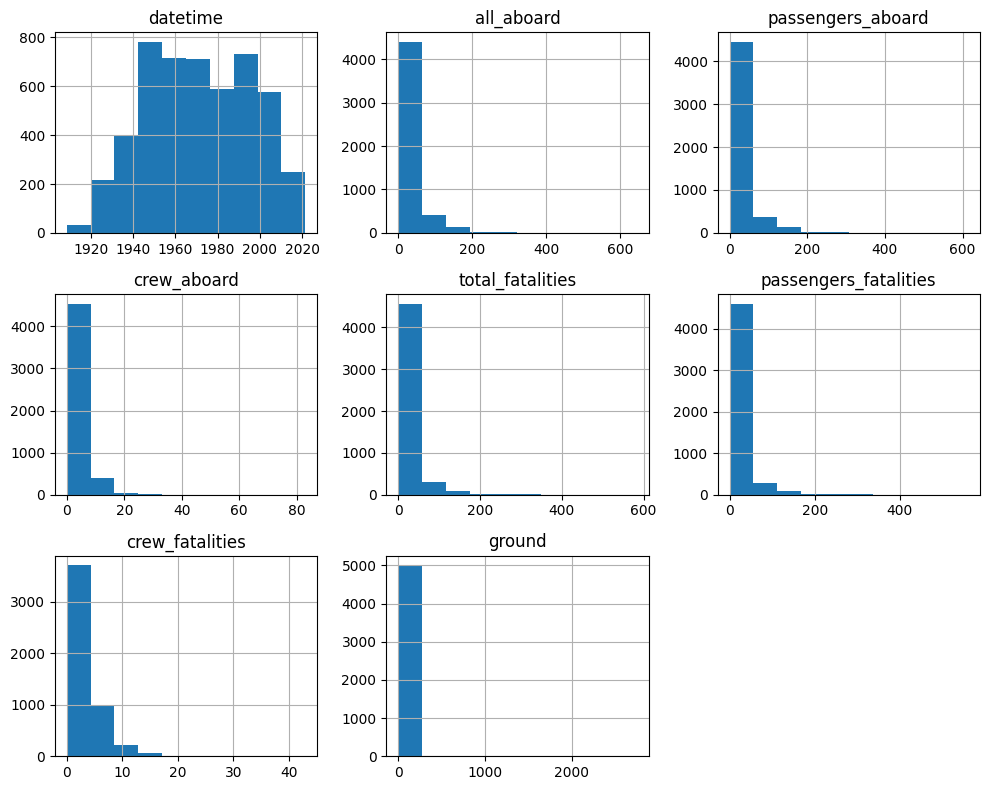

In [27]:
# distribucion de variables numericas
df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

C:\Users\BMO\AppData\Local\Temp\ipykernel_14560\2600159965.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


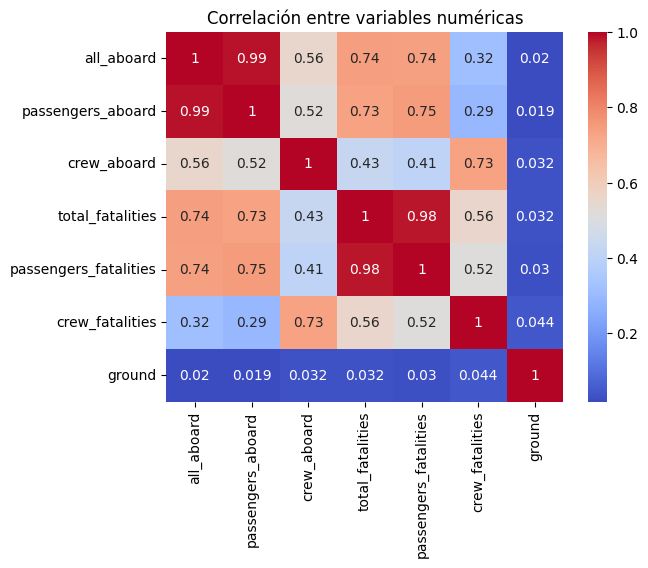

In [28]:
# correlacion entre variables numericas
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.show()

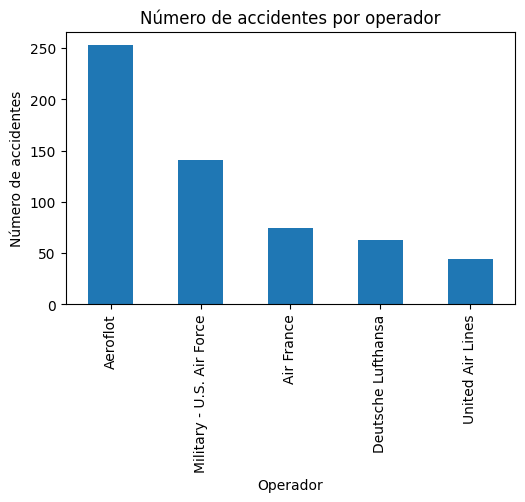

In [29]:
# numero de accidentes por operador
accidents_by_operator = df['operator'].value_counts().nlargest(5)


plt.figure(figsize=(10, 8))

# grafico de barras para numero de accidentes por operador
plt.subplot(2, 2, 1)
accidents_by_operator.plot(kind='bar')
plt.title('Número de accidentes por operador')
plt.xlabel('Operador')
plt.ylabel('Número de accidentes')

plt.tight_layout()
plt.show()


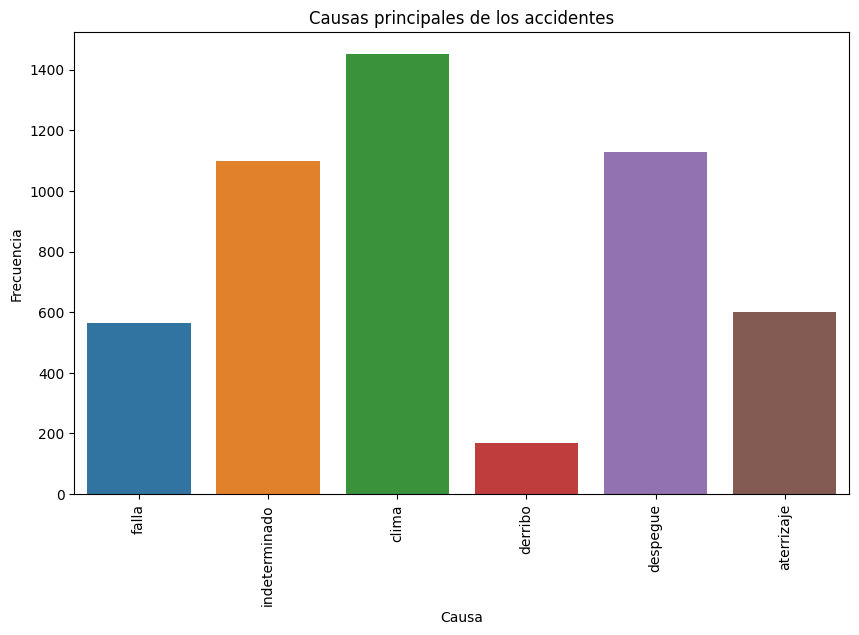

In [30]:
# grafico de barras para las causas principales de los accidentes
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df)
plt.xlabel('Causa')
plt.ylabel('Frecuencia')
plt.title('Causas principales de los accidentes')
plt.xticks(rotation=90)
plt.show()

In [31]:
# separamos el año en una columna a parte
df['year'] = df['datetime'].dt.year

In [32]:

total_abordo = df.groupby(['year', 'flight_type']).all_aboard.sum()
total_fatalities = df.groupby(['year', 'flight_type']).total_fatalities.sum()
df_mort = (total_fatalities / total_abordo).reset_index()
df_mort.columns=['year','flight_type', 'percentage_mort']

In [33]:
df_mort

,year,flight_type,percentage_mort
0,1908,Militar,0.500000
1,1909,Civil chico,1.000000
2,1912,Militar,1.000000
3,1913,Civil chico,1.000000
4,1913,Militar,0.875000
...,...,...,...
287,2020,Civil grande,0.461059
288,2020,Militar,0.977778
289,2021,Civil chico,0.937500
290,2021,Civil grande,1.000000


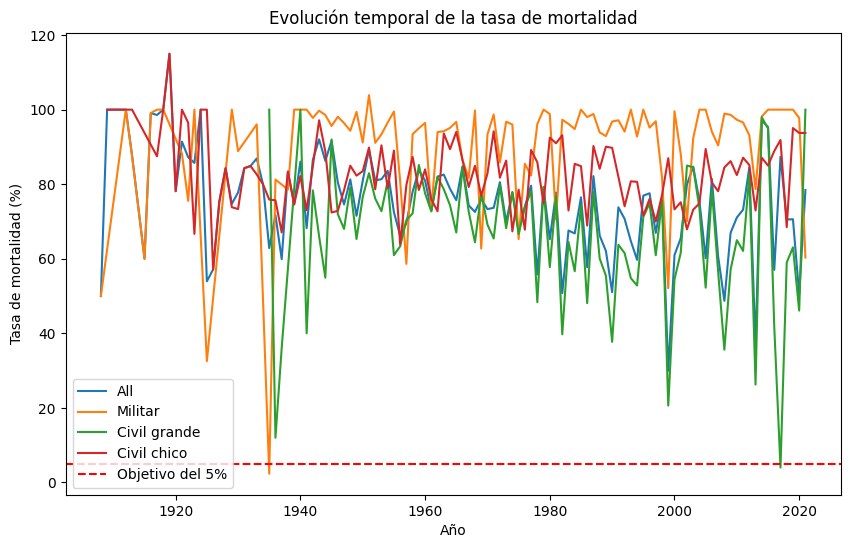

In [34]:
# calculamos la tasa de mortalidad por año
df0 = ((df.groupby('year').total_fatalities.sum()) / (df.groupby('year').all_aboard.sum())).reset_index()
df0.columns= ['year', 'percentage_mort']
df1 = df_mort.loc[df_mort['flight_type'] == 'Militar']
df2 = df_mort.loc[df_mort['flight_type'] == 'Civil grande']
df3 = df_mort.loc[df_mort['flight_type'] == 'Civil chico']

# grafico de línea para la evolución temporal de la tasa de mortalidad
plt.figure(figsize=(10, 6))
sns.lineplot(x=df0['year'], y=df0['percentage_mort'] * 100, label= 'All') 
sns.lineplot(x=df1['year'], y=df1['percentage_mort'] * 100, label= 'Militar')
sns.lineplot(x=df2['year'], y=df2['percentage_mort'] * 100, label= 'Civil grande')
sns.lineplot(x=df3['year'], y=df3['percentage_mort'] * 100, label= 'Civil chico')
plt.xlabel('Año')
plt.ylabel('Tasa de mortalidad (%)')
plt.title('Evolución temporal de la tasa de mortalidad')
plt.axhline(y=5, color='red', linestyle='--', label='Objetivo del 5%')
plt.legend()
plt.show()

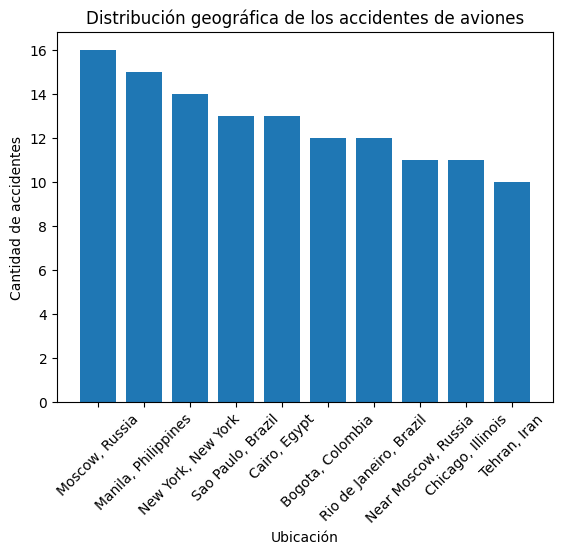

In [35]:
# obtenemos la cantidad de accidentes por ubicacion geografica
accidents_by_location = df['location'].value_counts()

# limitamos el numero de ubicaciones mas frecuentes a mostrar en el gráfico
num_locations = 10 
top_locations = accidents_by_location.head(num_locations)

# grafico de barras para visualizar la distribucian geografica de los accidentes
plt.bar(top_locations.index, top_locations.values)
plt.xlabel('Ubicación')
plt.ylabel('Cantidad de accidentes')
plt.title('Distribución geográfica de los accidentes de aviones')
plt.xticks(rotation=45)
plt.show()